In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, Model


# 1. Dataset paths

IMG_DIR = '/kaggle/input/nc4k-dataset/Imgs'
MASK_DIR = '/kaggle/input/nc4k-dataset/GT'
IMG_SIZE = (224, 224)

2025-10-21 14:25:27.764495: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761056727.978146     363 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761056728.036219     363 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:

# 2. Load dataset

def load_data(img_dir, mask_dir, img_size):
    img_files = sorted(os.listdir(img_dir))
    mask_files = sorted(os.listdir(mask_dir))
    images, masks = [], []

    for img_f, mask_f in zip(img_files, mask_files):
        img_path = os.path.join(img_dir, img_f)
        mask_path = os.path.join(mask_dir, mask_f)

        img = load_img(img_path, target_size=img_size)
        img = img_to_array(img) / 255.0

        mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")
        mask = img_to_array(mask) / 255.0

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

X, y = load_data(IMG_DIR, MASK_DIR, IMG_SIZE)

# Split dataset
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
print(f"✅ Dataset loaded: {X_train.shape[0]} train, {X_val.shape[0]} val")

✅ Dataset loaded: 3708 train, 413 val


In [ ]:

# 3. Build Saliency Enhancement Network (SEN)

class ConvBlock(layers.Layer):
    def __init__(self, filters, kernel_size=3):
        super().__init__()
        self.conv = layers.Conv2D(filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()
        self.relu = layers.ReLU()
    def call(self, x, training=False):
        x = self.conv(x)
        x = self.bn(x, training=training)
        return self.relu(x)

class ConvTransposeBlock(layers.Layer):
    def __init__(self, filters, kernel_size=4, strides=2):
        super().__init__()
        self.conv_t = layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding='same')
        self.bn = layers.BatchNormalization()
        self.relu = layers.ReLU()
    def call(self, x, training=False):
        x = self.conv_t(x)
        x = self.bn(x, training=training)
        return self.relu(x)

def build_sen(input_size=(224,224,3)):
    inputs = layers.Input(input_size)
    
    # Simple encoder
    c1 = ConvBlock(32)(inputs)
    p1 = layers.MaxPooling2D()(c1)
    
    c2 = ConvBlock(64)(p1)
    p2 = layers.MaxPooling2D()(c2)
    
    c3 = ConvBlock(128)(p2)
    
    # Decoder
    u1 = ConvTransposeBlock(64)(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = ConvBlock(64)(u1)
    
    u2 = ConvTransposeBlock(32)(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = ConvBlock(32)(u2)
    
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)
    
    return Model(inputs, outputs)

model = build_sen()
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1761056795.110955     363 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761056795.111720     363 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_block          │ (None, 224, 224,  │      1,024 │ input_layer[0][0] │
│ (ConvBlock)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv_block[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_block_1        │ (None, 112, 112,  │     18,752 │ max_pooling2d[0]… │
│ (ConvBlock)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv_block_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_block_2        │ (None, 56, 56,    │     74,368 │ max_pooling2d_1[… │
│ (ConvBlock)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_transpose_blo… │ (None, 112, 112,  │    131,392 │ conv_block_2[0][… │
│ (ConvTransposeBloc… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 112, 112,  │          0 │ conv_transpose_b… │
│ (Concatenate)       │ 128)              │            │ conv_block_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_block_3        │ (None, 112, 112,  │     74,048 │ concatenate[0][0] │
│ (ConvBlock)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_transpose_blo… │ (None, 224, 224,  │     32,928 │ conv_block_3[0][… │
│ (ConvTransposeBloc… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 224, 224,  │          0 │ conv_transpose_b… │
│ (Concatenate)       │ 64)               │            │ conv_block[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_block_4        │ (None, 224, 224,  │     18,592 │ concatenate_1[0]… │
│ (ConvBlock)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 224, 224,  │         33 │ conv_block_4[0][… │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 351,137 (1.34 MB)

 Trainable params: 350,305 (1.34 MB)

 Non-trainable params: 832 (3.25 KB)

In [ ]:

# 4. Train the model

model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=8, epochs=100)


Epoch 1/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 50s 81ms/step - accuracy: 0.8474 - loss: 0.3718 - val_accuracy: 0.8390 - val_loss: 0.3855
Epoch 2/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.8460 - loss: 0.3708 - val_accuracy: 0.8381 - val_loss: 0.3850
Epoch 3/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 30s 65ms/step - accuracy: 0.8469 - loss: 0.3671 - val_accuracy: 0.8391 - val_loss: 0.3796
Epoch 4/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step - accuracy: 0.8511 - loss: 0.3601 - val_accuracy: 0.8297 - val_loss: 0.3867
Epoch 5/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step - accuracy: 0.8484 - loss: 0.3633 - val_accuracy: 0.8397 - val_loss: 0.3793
Epoch 6/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 30s 65ms/step - accuracy: 0.8458 - loss: 0.3650 - val_accuracy: 0.8234 - val_loss: 0.3974
Epoch 7/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 30s 65ms/step - accuracy: 0.8497 - loss: 0.3558 - val_accuracy: 0.8401 - val_loss: 0.3784
Epoch 8/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 29s 64ms/step - accuracy: 0.8503 - loss: 0

In [ ]:

# 5. Save model

os.makedirs('checkpoints', exist_ok=True)
model.save('checkpoints/sen_model.h5')
print("✅ Model saved to checkpoints/sen_model.h5")


In [ ]:

# 6. Inference function

def infer_and_save(model, test_dir, output_dir, img_size):
    os.makedirs(output_dir, exist_ok=True)
    test_files = sorted(os.listdir(test_dir))

    for i, name in enumerate(test_files):
        img_path = os.path.join(test_dir, name)
        img = load_img(img_path, target_size=img_size)
        img_arr = img_to_array(img)/255.0
        img_arr = np.expand_dims(img_arr, 0)

        pred = model.predict(img_arr)[0]
        pred = (pred - pred.min()) / (pred.max() - pred.min() + 1e-8)
        pred_img = (pred * 255).astype('uint8')
        save_path = os.path.join(output_dir, name.replace(".jpg", "_pred.png"))
        Image.fromarray(pred_img.squeeze()).save(save_path)

        print(f"✅ Saved: {save_path}")

In [ ]:

# 7. Run inference

TEST_DIR = '/kaggle/input/cod10k-test/TestDataset/COD10K/Imgs'
OUTPUT_DIR = '/kaggle/working/results_sen'
infer_and_save(model, TEST_DIR, OUTPUT_DIR, IMG_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
✅ Saved: /kaggle/working/results_sen/COD10K-CAM-1-Aquatic-1-BatFish-2_pred.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
✅ Saved: /kaggle/working/results_sen/COD10K-CAM-1-Aquatic-1-BatFish-4_pred.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
✅ Saved: /kaggle/working/results_sen/COD10K-CAM-1-Aquatic-1-BatFish-5_pred.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
✅ Saved: /kaggle/working/results_sen/COD10K-CAM-1-Aquatic-1-BatFish-6_pred.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
✅ Saved: /kaggle/working/results_sen/COD10K-CAM-1-Aquatic-10-LeafySeaDragon-416_pred.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
✅ Saved: /kaggle/working/results_sen/COD10K-CAM-1-Aquatic-10-LeafySeaDragon-419_pred.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
✅ Saved: /kaggle/working/results_sen/COD10K-CAM-1-Aquatic-10-LeafySeaDragon-422_pred.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
✅ Saved: /kaggle/working/results_sen/COD10K-CAM-1-Aquatic-10-LeafySeaDragon-423_pred.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

KeyboardInterrupt: 

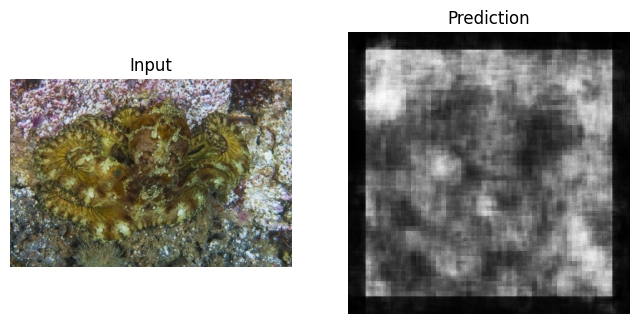

In [ ]:

# 8. Visualize a sample

sample_in = sorted(os.listdir(TEST_DIR))[11]
sample_out = sorted(os.listdir(OUTPUT_DIR))[11]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Input")
plt.imshow(load_img(os.path.join(TEST_DIR, sample_in)))
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Prediction")
plt.imshow(load_img(os.path.join(OUTPUT_DIR, sample_out)), cmap='gray')
plt.axis('off')
plt.show()